In [288]:
import numpy as np
import pandas as pd
from scipy.sparse import random
from datafold.dynfold import DMDFull, DMDEco
import matplotlib.pyplot as plt

### Tests on Linear dynamical system

Consider A as a matrix which has a complete set of eigen vectors and the system:
$$y_{m+1} = Ax_{m} - \sum_{i=0}^{i=m-1}\frac{<Ax_i,x_i>}{<x_i,x_i>}x_i$$

$$x_{m+1} = \frac{y_{m+1}}{||y_{m+1}||}$$

We use the Gram schmidt process to get linearly independent vectors in the p
oopagation of the dynamical system and consequently to make a Koopman matrix with large rank



### Generate data for the system

In [289]:
x_0 = np.random.rand(1000)   # 1000 - dimensional initial vector 
A = np.random.rand(1000, 1000)

In [290]:
A

array([[0.42750525, 0.05095821, 0.45734622, ..., 0.71572126, 0.70852433,
        0.98812352],
       [0.77449411, 0.10853996, 0.46757947, ..., 0.88614819, 0.74801684,
        0.15421408],
       [0.40360362, 0.17065514, 0.46785054, ..., 0.0816101 , 0.34484515,
        0.28341541],
       ...,
       [0.17527004, 0.65565193, 0.29518026, ..., 0.90629605, 0.21926118,
        0.50954596],
       [0.59690183, 0.21526285, 0.63662237, ..., 0.5998666 , 0.36101213,
        0.98799616],
       [0.57256071, 0.48755395, 0.07200108, ..., 0.53411053, 0.16035615,
        0.46184087]])

In [291]:
np.linalg.matrix_rank(A)

1000

In [292]:
np.linalg.cond(A)

530580.0746581742

In [293]:
x = x_0/np.linalg.norm(x_0)
data_matrix_all = np.zeros((1000,1001))
data_matrix_all[:,0] =  x

# data_matrix = x.reshape(1000,1)
# data_matrix_shifted = np.empty((1000,0))

for i in range(0,1000):
    y = A@x
    for j in range(0,i+1):
        y -= np.dot(data_matrix_all[:, j], y) / np.dot(data_matrix_all[:,j], data_matrix_all[:, j]) * data_matrix_all[:, j]
    
    y = y/np.linalg.norm(y)
    data_matrix_all[:, i+1] = y
    x= y 



###### By construction eigen vectors of this data matrix will be the columns?

In [294]:
data_matrix_all.shape[0]-1

999

In [295]:
data_matrix = data_matrix_all[:, 0:data_matrix_all.shape[1]-1]
data_matrix_shifted = data_matrix_all[:, 1:data_matrix_all.shape[1]]

data_matrix.shape, data_matrix_shifted.shape, data_matrix_all.shape

((1000, 1000), (1000, 1000), (1000, 1001))

In [296]:
data_matrix

array([[ 0.02547599,  0.01893545,  0.01327287, ..., -0.02772135,
         0.00805798,  0.00559651],
       [ 0.00546749,  0.05512925, -0.03937138, ...,  0.02073876,
        -0.03602205,  0.03929021],
       [ 0.0377246 , -0.0019208 , -0.04285449, ..., -0.00484199,
        -0.03685485,  0.00750959],
       ...,
       [ 0.00050871,  0.06382584, -0.02480146, ..., -0.00695979,
        -0.04037801,  0.03212872],
       [ 0.00542587,  0.05536716, -0.02673547, ..., -0.00951976,
         0.00495814,  0.04747391],
       [ 0.00919881,  0.04603117, -0.00994966, ...,  0.0182293 ,
        -0.02840028, -0.00770487]])

In [297]:
np.linalg.matrix_rank(data_matrix), np.linalg.matrix_rank(data_matrix_shifted)

(1000, 1000)

In [298]:
np.isnan(data_matrix).sum(), np.isnan(data_matrix_shifted).sum()

(0, 0)

In [299]:
data_matrix.shape

(1000, 1000)

In [300]:
# check if shifted matrices are constructed correctly
for i in range(0, data_matrix.shape[1]-1):
    if (data_matrix[:,i+1] != data_matrix_shifted[:,i]).any():
        print(i)

In [301]:
np.linalg.pinv(data_matrix)

array([[ 0.02547599,  0.00546749,  0.0377246 , ...,  0.00050871,
         0.00542587,  0.00919881],
       [ 0.01893545,  0.05512925, -0.0019208 , ...,  0.06382584,
         0.05536716,  0.04603117],
       [ 0.01327287, -0.03937138, -0.04285449, ..., -0.02480146,
        -0.02673547, -0.00994966],
       ...,
       [-0.02772135,  0.02073876, -0.00484199, ..., -0.00695979,
        -0.00951976,  0.0182293 ],
       [ 0.00805798, -0.03602205, -0.03685485, ..., -0.04037801,
         0.00495814, -0.02840028],
       [ 0.00559651,  0.03929021,  0.00750959, ...,  0.03212872,
         0.04747391, -0.00770487]])

In [302]:
np.linalg.matrix_rank(data_matrix)

1000

In [303]:
np.linalg.cond(data_matrix),np.linalg.cond(data_matrix_shifted)

(1.0000000000021252, 45.53376658366305)

### Generate Koopman matrix

Do this using $$K = X'X^{\dagger}$$

In [304]:
koopman_matrix = data_matrix_shifted @ np.linalg.pinv(data_matrix)
koopman_matrix.shape

(1000, 1000)

In [305]:
koopman_matrix

array([[ 0.02536309, -0.04686088, -0.00283962, ..., -0.0019438 ,
         0.07089698,  0.06144555],
       [ 0.01289592, -0.01774475,  0.02496513, ...,  0.05121996,
         0.00929492, -0.04117775],
       [-0.01400461, -0.07005001,  0.00700387, ..., -0.02081187,
        -0.00287501,  0.00842352],
       ...,
       [ 0.0042612 , -0.03442453, -0.02468248, ...,  0.02710883,
        -0.0148135 , -0.01307859],
       [ 0.08781703, -0.02982431,  0.01723202, ..., -0.00448327,
        -0.00388505,  0.03375101],
       [-0.01906019, -0.03113621, -0.06134134, ..., -0.01324834,
        -0.02834207,  0.00095575]])

#### Koopman matrix rank and condition number

In [306]:
np.linalg.matrix_rank(koopman_matrix)

1000

In [307]:
np.linalg.cond(koopman_matrix)

45.533766583662285

### Eigenvalue decomposition of Koopman matrix

In [308]:
eigenvalues_eigdecom, eigenvectors_eigdecom = np.linalg.eig(koopman_matrix)
np.max(eigenvalues_eigdecom)

(1.00021303971032+0.025060138780045878j)

In [309]:
eigenvalues_eigdecom

array([-0.75064378+0.66101544j, -0.75064378-0.66101544j,
       -0.73735844+0.6760012j , -0.73735844-0.6760012j ,
       -0.74098779+0.67052986j, -0.74098779-0.67052986j,
       -0.74469547+0.66538638j, -0.74469547-0.66538638j,
       -0.73272993+0.67998271j, -0.73272993-0.67998271j,
       -0.72898441+0.68521149j, -0.72898441-0.68521149j,
       -0.72337022+0.69142344j, -0.72337022-0.69142344j,
       -0.70688775+0.70881634j, -0.70688775-0.70881634j,
       -0.69705789+0.71715443j, -0.69705789-0.71715443j,
       -0.69173774+0.72386542j, -0.69173774-0.72386542j,
       -0.70235144+0.71254163j, -0.70235144-0.71254163j,
       -0.70976635+0.70185915j, -0.70976635-0.70185915j,
       -0.71661047+0.69663651j, -0.71661047-0.69663651j,
       -0.75572322+0.65466121j, -0.75572322-0.65466121j,
       -0.68524437+0.72729851j, -0.68524437-0.72729851j,
       -0.68138899+0.73169943j, -0.68138899-0.73169943j,
        0.75815021+0.65235055j,  0.75815021-0.65235055j,
        0.74892482+0.66211873j,

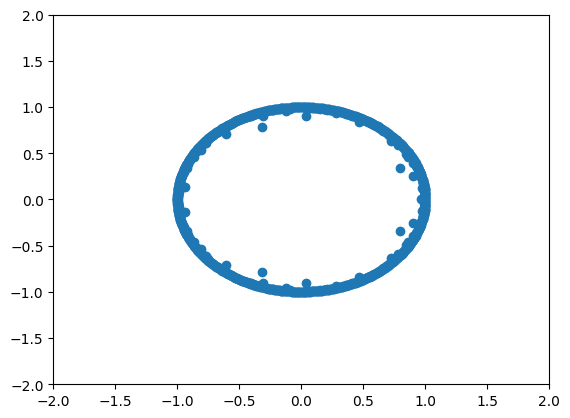

In [310]:
plt.scatter(eigenvalues_eigdecom.real, eigenvalues_eigdecom.imag)

# Set the axis limits
plt.xlim([-2, 2])
plt.ylim([-2, 2])

# Show the plot
plt.show()

In [312]:
eigenvectors_eigdecom.shape

(1000, 1000)

### check norm of eigen equation
$$Kv - \lambda v$$


In [142]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(koopman_matrix@eigenvectors_eigdecom[:,i] - eigenvalues_eigdecom[i]*eigenvectors_eigdecom[:,i])
    print(f"eigen value: {eigenvalues_eigdecom[i]}-- norm error: {e}")

eigen value: (0.7202185174128275+0.6923563574435778j)-- norm error: 1.489715030712696e-14
eigen value: (0.7202185174128275-0.6923563574435778j)-- norm error: 1.489715030712696e-14
eigen value: (0.7161003728566608+0.6979995633060034j)-- norm error: 1.4058364344303774e-14
eigen value: (0.7161003728566608-0.6979995633060034j)-- norm error: 1.4058364344303774e-14
eigen value: (0.7027532630461333+0.711329928405178j)-- norm error: 1.6567780171114266e-14
eigen value: (0.7027532630461333-0.711329928405178j)-- norm error: 1.6567780171114266e-14
eigen value: (0.70762195427365+0.706919325483086j)-- norm error: 1.7318495692235313e-14
eigen value: (0.70762195427365-0.706919325483086j)-- norm error: 1.7318495692235313e-14
eigen value: (0.7119515274301729+0.7022025930846028j)-- norm error: 1.514199867667857e-14
eigen value: (0.7119515274301729-0.7022025930846028j)-- norm error: 1.514199867667857e-14
eigen value: (0.6985627472243406+0.7159044712751298j)-- norm error: 1.3521104108753573e-14
eigen value

eigen value: (-0.6230623151037963+0.7826177282871416j)-- norm error: 1.5134969161353644e-14
eigen value: (-0.6230623151037963-0.7826177282871416j)-- norm error: 1.5134969161353644e-14
eigen value: (0.6230112935498485+0.7811970921075142j)-- norm error: 1.8045712418057147e-14
eigen value: (0.6230112935498485-0.7811970921075142j)-- norm error: 1.8045712418057147e-14
eigen value: (-0.778480558368682+0.627642577063616j)-- norm error: 1.8708869456450882e-14
eigen value: (-0.778480558368682-0.627642577063616j)-- norm error: 1.8708869456450882e-14
eigen value: (-0.782767866614154+0.6228170940501149j)-- norm error: 1.6351166938616615e-14
eigen value: (-0.782767866614154-0.6228170940501149j)-- norm error: 1.6351166938616615e-14
eigen value: (-0.6178807537284774+0.7863441729656377j)-- norm error: 2.6291884051847576e-14
eigen value: (-0.6178807537284774-0.7863441729656377j)-- norm error: 2.6291884051847576e-14
eigen value: (-0.7862119066070443+0.6171949497790019j)-- norm error: 1.999504299822154e-

eigen value: (0.8372977490841086-0.5458633007344673j)-- norm error: 1.579105871069886e-14
eigen value: (-0.5356364304290929+0.8448502466529847j)-- norm error: 1.8535902913649596e-14
eigen value: (-0.5356364304290929-0.8448502466529847j)-- norm error: 1.8535902913649596e-14
eigen value: (-0.8444150951236638+0.5362068819435533j)-- norm error: 1.7453721931786377e-14
eigen value: (-0.8444150951236638-0.5362068819435533j)-- norm error: 1.7453721931786377e-14
eigen value: (0.5403873610942707+0.8412014322823586j)-- norm error: 1.490562372109658e-14
eigen value: (0.5403873610942707-0.8412014322823586j)-- norm error: 1.490562372109658e-14
eigen value: (0.8408388274685115+0.5405767008559421j)-- norm error: 2.4906016582062832e-14
eigen value: (0.8408388274685115-0.5405767008559421j)-- norm error: 2.4906016582062832e-14
eigen value: (0.8433417845388225+0.5349983820851882j)-- norm error: 1.7597972290946983e-14
eigen value: (0.8433417845388225-0.5349983820851882j)-- norm error: 1.7597972290946983e-1

eigen value: (-0.896754596832525-0.4433371622980275j)-- norm error: 1.8105659522872432e-14
eigen value: (0.8930164984392582+0.4478244124197821j)-- norm error: 1.5117478750601908e-14
eigen value: (0.8930164984392582-0.4478244124197821j)-- norm error: 1.5117478750601908e-14
eigen value: (-0.8994295752436594+0.4368701570476326j)-- norm error: 1.9431538005132616e-14
eigen value: (-0.8994295752436594-0.4368701570476326j)-- norm error: 1.9431538005132616e-14
eigen value: (0.44240248374360824+0.8962618228642629j)-- norm error: 1.5367956893175972e-14
eigen value: (0.44240248374360824-0.8962618228642629j)-- norm error: 1.5367956893175972e-14
eigen value: (0.4368167911533249+0.8991880860928517j)-- norm error: 1.8054920049413594e-14
eigen value: (0.4368167911533249-0.8991880860928517j)-- norm error: 1.8054920049413594e-14
eigen value: (0.8956663376293018+0.4435654488164839j)-- norm error: 1.6189618801627137e-14
eigen value: (0.8956663376293018-0.4435654488164839j)-- norm error: 1.6189618801627137

eigen value: (0.9343006258608377+0.35730873144742814j)-- norm error: 2.109029636247706e-14
eigen value: (0.9343006258608377-0.35730873144742814j)-- norm error: 2.109029636247706e-14
eigen value: (0.3508844237946408+0.9367458517226356j)-- norm error: 1.403680272504192e-14
eigen value: (0.3508844237946408-0.9367458517226356j)-- norm error: 1.403680272504192e-14
eigen value: (-0.9367987835151523+0.35052983173857877j)-- norm error: 1.8317183976756157e-14
eigen value: (-0.9367987835151523-0.35052983173857877j)-- norm error: 1.8317183976756157e-14
eigen value: (0.9366162802966709+0.35083032288829247j)-- norm error: 1.6942413539864842e-14
eigen value: (0.9366162802966709-0.35083032288829247j)-- norm error: 1.6942413539864842e-14
eigen value: (0.9390912481417788+0.34509471934004377j)-- norm error: 2.4278077493639106e-14
eigen value: (0.9390912481417788-0.34509471934004377j)-- norm error: 2.4278077493639106e-14
eigen value: (0.345001807339764+0.9382155791040894j)-- norm error: 1.436487860173360

eigen value: (0.2786701161286894-0.9601701724967386j)-- norm error: 1.426636649832473e-14
eigen value: (0.9566075161213565+0.29058503877840647j)-- norm error: 1.4202851395671096e-14
eigen value: (0.9566075161213565-0.29058503877840647j)-- norm error: 1.4202851395671096e-14
eigen value: (-0.28495099683067937+0.9585544455976246j)-- norm error: 1.513217735029625e-14
eigen value: (-0.28495099683067937-0.9585544455976246j)-- norm error: 1.513217735029625e-14
eigen value: (0.2730102229664023+0.9617541067779541j)-- norm error: 1.7891856744546673e-14
eigen value: (0.2730102229664023-0.9617541067779541j)-- norm error: 1.7891856744546673e-14
eigen value: (0.9571436252712652+0.2849958495662473j)-- norm error: 1.8412604384098342e-14
eigen value: (0.9571436252712652-0.2849958495662473j)-- norm error: 1.8412604384098342e-14
eigen value: (-0.2785551100001229+0.961140896325059j)-- norm error: 1.6725815747724293e-14
eigen value: (-0.2785551100001229-0.961140896325059j)-- norm error: 1.6725815747724293e

eigen value: (0.9857958717484785+0.16904769328186178j)-- norm error: 2.782657931716539e-14
eigen value: (0.9857958717484785-0.16904769328186178j)-- norm error: 2.782657931716539e-14
eigen value: (-0.9842573771830598+0.1753663169994421j)-- norm error: 2.111999842997427e-14
eigen value: (-0.9842573771830598-0.1753663169994421j)-- norm error: 2.111999842997427e-14
eigen value: (-0.985738120547526+0.1692888391012527j)-- norm error: 2.0660863207226076e-14
eigen value: (-0.985738120547526-0.1692888391012527j)-- norm error: 2.0660863207226076e-14
eigen value: (-0.1935475768690945+0.9812142793352404j)-- norm error: 1.6424510956206232e-14
eigen value: (-0.1935475768690945-0.9812142793352404j)-- norm error: 1.6424510956206232e-14
eigen value: (0.1874236718900819+0.9816832702471602j)-- norm error: 1.837845588560029e-14
eigen value: (0.1874236718900819-0.9816832702471602j)-- norm error: 1.837845588560029e-14
eigen value: (-0.18700074895312313+0.9826138705070689j)-- norm error: 1.703417082819133e-1

eigen value: (-0.08834809119260023+0.9952148082836992j)-- norm error: 1.4179414260411478e-14
eigen value: (-0.08834809119260023-0.9952148082836992j)-- norm error: 1.4179414260411478e-14
eigen value: (0.08767512703482197+0.9959262555554959j)-- norm error: 1.5107373868964114e-14
eigen value: (0.08767512703482197-0.9959262555554959j)-- norm error: 1.5107373868964114e-14
eigen value: (-0.08166373940477939+0.9966928211592431j)-- norm error: 1.8155912408540536e-14
eigen value: (-0.08166373940477939-0.9966928211592431j)-- norm error: 1.8155912408540536e-14
eigen value: (0.08184324912775987+0.9957526558658736j)-- norm error: 1.3779972173105211e-14
eigen value: (0.08184324912775987-0.9957526558658736j)-- norm error: 1.3779972173105211e-14
eigen value: (-0.07518778581122748+0.9971520492798029j)-- norm error: 2.032444817486879e-14
eigen value: (-0.07518778581122748-0.9971520492798029j)-- norm error: 2.032444817486879e-14
eigen value: (-0.018458819860461405+1.000087038114753j)-- norm error: 1.3941

In [143]:
np.allclose(koopman_matrix@eigenvectors_eigdecom[:,i], eigenvalues_eigdecom[i]*eigenvectors_eigdecom[:,i])

True

#### Check eigen equation for integer power of eigen vector and eigen value

##### exponent 2

In [313]:
np.allclose(koopman_matrix@(eigenvectors_eigdecom[:,0]**2), 
            (eigenvalues_eigdecom[0]**2)*(eigenvectors_eigdecom[:,0]**2))

False

In [322]:
koopman_matrix@(eigenvectors_eigdecom[:,0]**2)- (eigenvalues_eigdecom[0]**2)*(eigenvectors_eigdecom[:,0]**2)

array([ 4.41415882e-04+1.24399672e-03j, -9.79265882e-04-8.91575397e-04j,
        6.31378255e-04+2.28485172e-03j, -7.15905115e-04+1.37414448e-03j,
        1.71247451e-03+3.32157521e-04j, -1.06377781e-03-8.23231023e-04j,
       -1.47475298e-04-5.64093689e-04j,  5.10226693e-04-1.49900809e-03j,
       -2.19500718e-03+7.97327229e-04j, -5.40575000e-05+3.36005893e-03j,
       -1.55603426e-03+2.02381701e-03j, -1.14042410e-03-2.04062480e-03j,
        1.67332269e-03-1.03187350e-03j,  4.93684284e-04-2.44235429e-03j,
       -3.85733287e-03-5.32871165e-04j,  1.14134041e-03-3.82712927e-04j,
       -7.15105725e-04+2.86280836e-04j, -1.46372298e-03+1.10434005e-03j,
       -1.03223274e-03-2.13978191e-05j,  2.19776530e-06-3.44194755e-04j,
       -1.73466817e-03+9.83884740e-04j, -1.83891477e-03+2.19130298e-04j,
        1.97196048e-04-2.41938250e-03j,  1.78622152e-03-6.13306798e-04j,
        1.76686692e-04+8.04213354e-04j,  1.51198544e-04-5.71299676e-05j,
        3.22692726e-04-1.06509191e-03j, -5.89424412

In [316]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(koopman_matrix@(eigenvectors_eigdecom[:,i]**2) 
                       - (eigenvalues_eigdecom[i]**2)*(eigenvectors_eigdecom[:,i]**2))
    print(f"eigen value: {eigenvalues_eigdecom[i]}-- norm error: {e}")

eigen value: (-0.7506437829172848+0.6610154358709188j)-- norm error: 0.06492537304384009
eigen value: (-0.7506437829172848-0.6610154358709188j)-- norm error: 0.06492537304384009
eigen value: (-0.7373584380145368+0.6760011968705221j)-- norm error: 0.06263913674048692
eigen value: (-0.7373584380145368-0.6760011968705221j)-- norm error: 0.06263913674048692
eigen value: (-0.7409877929015158+0.6705298636624558j)-- norm error: 0.061177167566996454
eigen value: (-0.7409877929015158-0.6705298636624558j)-- norm error: 0.061177167566996454
eigen value: (-0.7446954660011432+0.6653863801184191j)-- norm error: 0.06260231387823094
eigen value: (-0.7446954660011432-0.6653863801184191j)-- norm error: 0.06260231387823094
eigen value: (-0.7327299282174687+0.6799827127770963j)-- norm error: 0.06208480483415571
eigen value: (-0.7327299282174687-0.6799827127770963j)-- norm error: 0.06208480483415571
eigen value: (-0.7289844115642835+0.6852114901890772j)-- norm error: 0.06425086341707532
eigen value: (-0.72

eigen value: (0.8092180666283285+0.5821246716742399j)-- norm error: 0.06579740152527744
eigen value: (0.8092180666283285-0.5821246716742399j)-- norm error: 0.06579740152527744
eigen value: (0.815933116566036+0.5770336898315804j)-- norm error: 0.06201642272230413
eigen value: (0.815933116566036-0.5770336898315804j)-- norm error: 0.06201642272230413
eigen value: (0.5669135590054598+0.8235587275378596j)-- norm error: 0.06226806727841384
eigen value: (0.5669135590054598-0.8235587275378596j)-- norm error: 0.06226806727841384
eigen value: (0.8221452479599531+0.5699417420668699j)-- norm error: 0.0635233446908276
eigen value: (0.8221452479599531-0.5699417420668699j)-- norm error: 0.0635233446908276
eigen value: (-0.7712605080846682+0.6130596221106427j)-- norm error: 0.06131026919357185
eigen value: (-0.7712605080846682-0.6130596221106427j)-- norm error: 0.06131026919357185
eigen value: (-0.8085157870006185+0.5780784968946454j)-- norm error: 0.06475286079395468
eigen value: (-0.8085157870006185

eigen value: (-0.8733191247167164+0.4867988193438482j)-- norm error: 0.06165075105548052
eigen value: (-0.8733191247167164-0.4867988193438482j)-- norm error: 0.06165075105548052
eigen value: (0.4792602447482751+0.8772363315807136j)-- norm error: 0.06388404843087638
eigen value: (0.4792602447482751-0.8772363315807136j)-- norm error: 0.06388404843087638
eigen value: (0.8751117970154288+0.48382105229603745j)-- norm error: 0.06223151869611684
eigen value: (0.8751117970154288-0.48382105229603745j)-- norm error: 0.06223151869611684
eigen value: (0.47380839581303436+0.8810751791749297j)-- norm error: 0.06318165569419784
eigen value: (0.47380839581303436-0.8810751791749297j)-- norm error: 0.06318165569419784
eigen value: (-0.4783697106091984+0.8770989956096041j)-- norm error: 0.06558174935664557
eigen value: (-0.4783697106091984-0.8770989956096041j)-- norm error: 0.06558174935664557
eigen value: (0.8788067438527398+0.4779079115483449j)-- norm error: 0.06316901346233043
eigen value: (0.87880674

eigen value: (-0.942732232292349+0.33519190814886934j)-- norm error: 0.06290369255402205
eigen value: (-0.942732232292349-0.33519190814886934j)-- norm error: 0.06290369255402205
eigen value: (-0.32564122356804653+0.9457851025208629j)-- norm error: 0.06223978680120681
eigen value: (-0.32564122356804653-0.9457851025208629j)-- norm error: 0.06223978680120681
eigen value: (-0.943894616771308+0.3287133337055872j)-- norm error: 0.06420665146940434
eigen value: (-0.943894616771308-0.3287133337055872j)-- norm error: 0.06420665146940434
eigen value: (0.32517955493891937+0.9439607743419173j)-- norm error: 0.06156362546851784
eigen value: (0.32517955493891937-0.9439607743419173j)-- norm error: 0.06156362546851784
eigen value: (-0.3193182422644583+0.945225091664649j)-- norm error: 0.06290854065762992
eigen value: (-0.3193182422644583-0.945225091664649j)-- norm error: 0.06290854065762992
eigen value: (0.3194649117361106+0.9467329146164358j)-- norm error: 0.06220372314430456
eigen value: (0.31946491

eigen value: (0.9873893541225249-0.16318645216354685j)-- norm error: 0.06497591999239366
eigen value: (-0.9833575376424213+0.17864854451672554j)-- norm error: 0.06297226018323972
eigen value: (-0.9833575376424213-0.17864854451672554j)-- norm error: 0.06297226018323972
eigen value: (-0.172882147552546+0.9843070282433881j)-- norm error: 0.06489195597675584
eigen value: (-0.172882147552546-0.9843070282433881j)-- norm error: 0.06489195597675584
eigen value: (0.9876296655458474+0.15577644411037858j)-- norm error: 0.06386413040640428
eigen value: (0.9876296655458474-0.15577644411037858j)-- norm error: 0.06386413040640428
eigen value: (0.18120112130310867+0.9817771457173865j)-- norm error: 0.06373109204985608
eigen value: (0.18120112130310867-0.9817771457173865j)-- norm error: 0.06373109204985608
eigen value: (-0.16760032402305006+0.9855589507305266j)-- norm error: 0.06184698633560246
eigen value: (-0.16760032402305006-0.9855589507305266j)-- norm error: 0.06184698633560246
eigen value: (0.174

eigen value: (0.020908699239163775-0.9992156056036325j)-- norm error: 0.06431203148162112
eigen value: (0.01893629362558666+0.9983139165240869j)-- norm error: 0.06360840795563426
eigen value: (0.01893629362558666-0.9983139165240869j)-- norm error: 0.06360840795563426
eigen value: (0.9969332869716394+0.06035044762577556j)-- norm error: 0.06447451844154824
eigen value: (0.9969332869716394-0.06035044762577556j)-- norm error: 0.06447451844154824
eigen value: (0.9957948595336199+0.056518656952171856j)-- norm error: 0.06372271632303964
eigen value: (0.9957948595336199-0.056518656952171856j)-- norm error: 0.06372271632303964
eigen value: (0.994992796162451+0.06898356871229627j)-- norm error: 0.06471970993902099
eigen value: (0.994992796162451-0.06898356871229627j)-- norm error: 0.06471970993902099
eigen value: (0.9678705996651645+0j)-- norm error: 0.06755989103700248
eigen value: (-0.9914916700565328+0.05266497030201649j)-- norm error: 0.06309251289657311
eigen value: (-0.9914916700565328-0.0

##### exponent 3

In [317]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(koopman_matrix@(eigenvectors_eigdecom[:,i]**2) 
                       - (eigenvalues_eigdecom[i]**3)*(eigenvectors_eigdecom[:,i]**3))
    print(f"eigen value: {eigenvalues_eigdecom[i]}-- norm error: {e}")

eigen value: (-0.7506437829172848+0.6610154358709188j)-- norm error: 0.045998077055301324
eigen value: (-0.7506437829172848-0.6610154358709188j)-- norm error: 0.045998077055301324
eigen value: (-0.7373584380145368+0.6760011968705221j)-- norm error: 0.04363855275300971
eigen value: (-0.7373584380145368-0.6760011968705221j)-- norm error: 0.04363855275300971
eigen value: (-0.7409877929015158+0.6705298636624558j)-- norm error: 0.04371127475380264
eigen value: (-0.7409877929015158-0.6705298636624558j)-- norm error: 0.04371127475380264
eigen value: (-0.7446954660011432+0.6653863801184191j)-- norm error: 0.0449407741476882
eigen value: (-0.7446954660011432-0.6653863801184191j)-- norm error: 0.0449407741476882
eigen value: (-0.7327299282174687+0.6799827127770963j)-- norm error: 0.04428146772424664
eigen value: (-0.7327299282174687-0.6799827127770963j)-- norm error: 0.04428146772424664
eigen value: (-0.7289844115642835+0.6852114901890772j)-- norm error: 0.04590740965342117
eigen value: (-0.7289

eigen value: (0.7771607463326186+0.6201039854593373j)-- norm error: 0.043528957224235845
eigen value: (0.7771607463326186-0.6201039854593373j)-- norm error: 0.043528957224235845
eigen value: (-0.8010870317419791+0.5994876127472374j)-- norm error: 0.043823700888531644
eigen value: (-0.8010870317419791-0.5994876127472374j)-- norm error: 0.043823700888531644
eigen value: (-0.608946635328032+0.7918659738519286j)-- norm error: 0.04620492516425007
eigen value: (-0.608946635328032-0.7918659738519286j)-- norm error: 0.04620492516425007
eigen value: (0.7890678636999509+0.6114500731263873j)-- norm error: 0.044752359796583506
eigen value: (0.7890678636999509-0.6114500731263873j)-- norm error: 0.044752359796583506
eigen value: (0.7857859285059712+0.6137575419144691j)-- norm error: 0.04320894610615793
eigen value: (0.7857859285059712-0.6137575419144691j)-- norm error: 0.04320894610615793
eigen value: (-0.6030333599490828+0.7970887053168748j)-- norm error: 0.044050396318031676
eigen value: (-0.60303

eigen value: (-0.512856051126861-0.8584322314722973j)-- norm error: 0.04581268178394883
eigen value: (0.8431600525037304+0.5286505484663492j)-- norm error: 0.04592798270717344
eigen value: (0.8431600525037304-0.5286505484663492j)-- norm error: 0.04592798270717344
eigen value: (0.7773227036300581+0.5881215979500778j)-- norm error: 0.04561041863561897
eigen value: (0.7773227036300581-0.5881215979500778j)-- norm error: 0.04561041863561897
eigen value: (0.5188971581062849+0.8538786898537012j)-- norm error: 0.04359946572233547
eigen value: (0.5188971581062849-0.8538786898537012j)-- norm error: 0.04359946572233547
eigen value: (0.5237320242576953+0.8485404115435045j)-- norm error: 0.04350166032982265
eigen value: (0.5237320242576953-0.8485404115435045j)-- norm error: 0.04350166032982265
eigen value: (0.513599532531688+0.8571484076470326j)-- norm error: 0.045339202928238696
eigen value: (0.513599532531688-0.8571484076470326j)-- norm error: 0.045339202928238696
eigen value: (0.8565941019054728

eigen value: (0.4034697763774375-0.9151538850406562j)-- norm error: 0.04441928543449992
eigen value: (-0.40238299865865346+0.9080857608198247j)-- norm error: 0.04472688484272119
eigen value: (-0.40238299865865346-0.9080857608198247j)-- norm error: 0.04472688484272119
eigen value: (-0.914638344153454+0.4027112660959126j)-- norm error: 0.04483699609643427
eigen value: (-0.914638344153454-0.4027112660959126j)-- norm error: 0.04483699609643427
eigen value: (0.9132417068523861+0.40234015319389027j)-- norm error: 0.043959094299597316
eigen value: (0.9132417068523861-0.40234015319389027j)-- norm error: 0.043959094299597316
eigen value: (0.914768220444222+0.39756198453404673j)-- norm error: 0.044879557674523035
eigen value: (0.914768220444222-0.39756198453404673j)-- norm error: 0.044879557674523035
eigen value: (0.9207411171335286+0.39094143020727806j)-- norm error: 0.04477120889736651
eigen value: (0.9207411171335286-0.39094143020727806j)-- norm error: 0.04477120889736651
eigen value: (0.4615

eigen value: (-0.9488287769332355-0.314962814878904j)-- norm error: 0.04416146584084863
eigen value: (-0.3125623408967639+0.9482911909491437j)-- norm error: 0.04520058149624012
eigen value: (-0.3125623408967639-0.9482911909491437j)-- norm error: 0.04520058149624012
eigen value: (-0.9184202772673374+0.33771207422204247j)-- norm error: 0.0452392668398444
eigen value: (-0.9184202772673374-0.33771207422204247j)-- norm error: 0.0452392668398444
eigen value: (0.3070423561919744+0.9523691081854834j)-- norm error: 0.045156064130343634
eigen value: (0.3070423561919744-0.9523691081854834j)-- norm error: 0.045156064130343634
eigen value: (0.951896152211005+0.3099640358282003j)-- norm error: 0.04424540594333019
eigen value: (0.951896152211005-0.3099640358282003j)-- norm error: 0.04424540594333019
eigen value: (-0.3077251730686228+0.951115007139708j)-- norm error: 0.04458443695060927
eigen value: (-0.3077251730686228-0.951115007139708j)-- norm error: 0.04458443695060927
eigen value: (-0.95021632562

eigen value: (-0.971344958338183+0.2295904021293876j)-- norm error: 0.04477101796482079
eigen value: (-0.971344958338183-0.2295904021293876j)-- norm error: 0.04477101796482079
eigen value: (-0.9746007126181432+0.22327154831436585j)-- norm error: 0.0453451383352106
eigen value: (-0.9746007126181432-0.22327154831436585j)-- norm error: 0.0453451383352106
eigen value: (-0.31098628312430043+0.9001331936075325j)-- norm error: 0.043729071283883536
eigen value: (-0.31098628312430043-0.9001331936075325j)-- norm error: 0.043729071283883536
eigen value: (-0.2413051914277879+0.9704668814200983j)-- norm error: 0.04531492962703696
eigen value: (-0.2413051914277879-0.9704668814200983j)-- norm error: 0.04531492962703696
eigen value: (0.2762272639415494+0.9374680107803505j)-- norm error: 0.043663126667847905
eigen value: (0.2762272639415494-0.9374680107803505j)-- norm error: 0.043663126667847905
eigen value: (0.2542839701320053+0.9639087135559486j)-- norm error: 0.04520022899218702
eigen value: (0.2542

eigen value: (-0.9879232900625949-0.1468291228784161j)-- norm error: 0.043417041237202685
eigen value: (0.15177712738601395+0.9872709649443899j)-- norm error: 0.044661513418849726
eigen value: (0.15177712738601395-0.9872709649443899j)-- norm error: 0.044661513418849726
eigen value: (0.9882101119075586+0.13556931125049698j)-- norm error: 0.04363672427807016
eigen value: (0.9882101119075586-0.13556931125049698j)-- norm error: 0.04363672427807016
eigen value: (0.15348480885098514+0.9835759049314922j)-- norm error: 0.04439005833528313
eigen value: (0.15348480885098514-0.9835759049314922j)-- norm error: 0.04439005833528313
eigen value: (-0.9899894747885093+0.14140549611636377j)-- norm error: 0.04501257836933695
eigen value: (-0.9899894747885093-0.14140549611636377j)-- norm error: 0.04501257836933695
eigen value: (0.993256779175492+0.1220815942078133j)-- norm error: 0.04512007613536496
eigen value: (0.993256779175492-0.1220815942078133j)-- norm error: 0.04512007613536496
eigen value: (-0.141

eigen value: (-0.9974011133458721-0.06271031538863249j)-- norm error: 0.044844146045212946
eigen value: (-0.997799947383764+0.05433312033507039j)-- norm error: 0.044508443503944124
eigen value: (-0.997799947383764-0.05433312033507039j)-- norm error: 0.044508443503944124
eigen value: (-0.9978005783543888+0.034280538578595476j)-- norm error: 0.044061236048407774
eigen value: (-0.9978005783543888-0.034280538578595476j)-- norm error: 0.044061236048407774
eigen value: (0.03858815844086429+0.9994367690168686j)-- norm error: 0.044998686201948225
eigen value: (0.03858815844086429-0.9994367690168686j)-- norm error: 0.044998686201948225
eigen value: (-0.07206083465486204+0.9970307827133144j)-- norm error: 0.044482005835297385
eigen value: (-0.07206083465486204-0.9970307827133144j)-- norm error: 0.044482005835297385
eigen value: (-0.06294537408566461+0.9970318250083717j)-- norm error: 0.04433360859684094
eigen value: (-0.06294537408566461-0.9970318250083717j)-- norm error: 0.04433360859684094
eig

#### check eigen equation for successive products of eigen vectors and eigenvalues

In [318]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(koopman_matrix@(eigenvectors_eigdecom[:,i]*eigenvectors_eigdecom[:,i+1]) 
                       - (eigenvalues_eigdecom[i]*eigenvalues_eigdecom[i+1])*(eigenvectors_eigdecom[:,i]*eigenvectors_eigdecom[:,i+1]))
    print(e)

0.05775871529697155
0.0452743358856397
0.05414404750630218
0.04622899056909612
0.05425787567492427
0.04591043040304383
0.05634234389817652
0.044562210241162935
0.05502380197492165
0.04426749833124127
0.05893860619559738
0.04566040751349102
0.05440626298001584
0.04485025003855157
0.05557625978991883
0.04584236673601023
0.05546771228410695
0.044216868476374675
0.05529186818009756
0.04456500682841955
0.05609570497819415
0.043767304273109195
0.0563323158012086
0.04621609707002625
0.05641813252713034
0.04309258385429729
0.05566586246944931
0.045215863079262515
0.05705492917839573
0.045671871723527616
0.05710717993459506
0.044027052330933444
0.056812630495451294
0.04705837404607552
0.05549293132925943
0.04436537921813274
0.057015139049012876
0.047490644487478334
0.05853067810025559
0.044632147841530995
0.05622581900991455
0.04383078128790373
0.05486908901610909
0.044542306836187505
0.05686863510140976
0.04487590808384778
0.05529070652201751
0.045500014124586076
0.057152918585391566
0.0449506

0.04499992627672245
0.0573959857153345
0.04595296247509041
0.054541498926454095
0.04491134163744413
0.05586313714360619
0.043726172061185925
0.055290215421049095
0.04391735170049086
0.055864356326467114
0.04391663538921445
0.05609603790078711
0.0448393613038882
0.05410691841649246
0.04491200579458684
0.05642236732157812
0.0434340812879331
0.05621516482076354
0.04457454905480157
0.05619740646523587
0.045663432300890615
0.055459870895639404
0.044963876466782494
0.056255440253448835
0.04430035296537104
0.05472611059986586
0.04405769789695344
0.05594167440513447
0.05347148104152482
0.056208793590678326
0.04383718105403343
0.05652857683597227
0.043895069280930274
0.057945533578727504
0.04543702649415059
0.0545448808689397
0.045286736096814904
0.056087019406667424
0.044391464857267054
0.05568677725799092
0.04584345389295956
0.05618844448923155
0.045116641447506003
0.056021703236221305
0.04313500886653158
0.05799175729271475
0.04668792633285253
0.05481089074956961
0.044981198385781684
0.05786

IndexError: index 1000 is out of bounds for axis 1 with size 1000

--------END OF NOTEBOOK---------------------

### Power iteration

In [ ]:
def power_iteration(A, max_iterations = 10000, tolerance=1e-6):
    eig_old = 0
    x = np.random.rand(A.shape[1])
    x = x/np.linalg.norm(x)
    for i in range(max_iterations):
        y = np.dot(A, x)
        norm = np.linalg.norm(y)
        x = y / norm 
        eigenvalue = np.dot(np.dot(x, A), x.T)
        if np.abs(eig_old - eigenvalue) < tolerance:
            return x, eigenvalue
        else:
            eig_old = eigenvalue
    
    print("max iter reached", eig_old - eigenvalue)
    return x, eigenvalue

In [ ]:
def power_iteration_with_deflation(A, num_eigen, num_iterations):
    eigs = []
    
    for i in range(num_eigen):
        eigvec, eigvalue = power_iteration(A, num_iterations)
        eigs.append((eigvec, eigvalue))
        A = A - eigvec@eigvec.T

In [29]:
def deflate_matrix(A, vec):
    return A - vec@vec.T

In [ ]:
eigenvec, eigenvalue = power_iteration(koopman_matrix)
eigenvec, eigenvalue

In [ ]:
power_iteration(deflate_matrix(A, eigenvec), num_iterations=1000)

### QR decomposition

In [ ]:
Q, R = np.linalg.qr(koopman_matrix)

In [ ]:
np.linalg.eigvals(R)

In [1459]:
np.max(np.linalg.eigvals(R))

1.002482480439295

In [ ]:
plt.scatter(np.linalg.eigvals(R).real, np.linalg.eigvals(R).imag)

# Set the axis limits
plt.xlim([-2, 2])
plt.ylim([-2, 2])

# Show the plot
plt.show()

In [ ]:
np.abs(eigenvalues_eigdecom)

In [1240]:
eigenvectors_eigdecom.shape

(100, 100)

In [1241]:
np.linalg.matrix_rank(data_matrix)

27

### using datafold

In [222]:
from datafold.pcfold import GaussianKernel, TSCDataFrame


In [223]:
tsc_data = TSCDataFrame.from_single_timeseries(pd.DataFrame(data_matrix_all.T))
tsc_data

feature       0         1         2         3         4         5         6    \
ID time                                                                         
0  0     0.020679  0.036973  0.029002  0.002360  0.035740  0.000684  0.045469   
   1     0.026501 -0.001251  0.012199  0.058683  0.002823  0.060371 -0.014806   
   2     0.030755 -0.031188 -0.002087 -0.046118 -0.024312 -0.012717 -0.012157   
   3     0.032076 -0.052260  0.075147  0.008236 -0.034656 -0.058030  0.077633   
   4     0.017654  0.016590  0.001189 -0.051953 -0.051744  0.002068 -0.019143   
...           ...       ...       ...       ...       ...       ...       ...   
   996  -0.053043  0.021538  0.023985 -0.032417  0.008412 -0.016124 -0.049003   
   997  -0.033747 -0.028636 -0.033339  0.019823 -0.005104 -0.010553 -0.012666   
   998   0.016190 -0.028814  0.021190  0.004625 -0.017199 -0.004323  0.046821   
   999  -0.024647  0.021501  0.059056  0.042592 -0.002440  0.038385  0.004459   
   1000  0.017548  0.034778  0.022646 -0.002486  0.030725 -0.003647  0.045165   

feature       7         8         9    ...       990       991       992  \
ID time                                ...                                 
0  0     0.007183  0.016247  0.009499  ...  0.032147  0.008021  0.022045   
   1     0.051880  0.036348  0.046180  ...  0.006387  0.049260  0.026121   
   2    -0.028933 -0.018975 -0.029954  ... -0.017891  0.003693 -0.018161   
   3    -0.001388 -0.015976  0.002765  ...  0.017408 -0.061191  0.031763   
   4     0.034604 -0.002606  0.011233  ... -0.036758 -0.021407 -0.011399   
...           ...       ...       ...  ...       ...       ...       ...   
   996  -0.020688  0.009578  0.010918  ...  0.012314 -0.005925  0.046216   
   997  -0.024265  0.017450 -0.061553  ...  0.004176 -0.081430 -0.010740   
   998   0.003637 -0.003005 -0.009100  ... -0.004278 -0.019437  0.021290   
   999   0.004593 -0.037082  0.018020  ...  0.015724  0.019746  0.004950   
   1000 -0.016973  0.015941 -0.001860  ...  0.035347  0.010048  0.030201   

feature       993       994       995       996       997       998       999  
ID time                                                                        
0  0     0.050357  0.051896  0.053307  0.006274  0.003403  0.015372  0.035648  
   1    -0.020783 -0.028468 -0.030513  0.051681  0.058127  0.036590  0.002322  
   2    -0.058205  0.016006 -0.028735  0.024918 -0.042832 -0.009093  0.008196  
   3    -0.037686  0.018547 -0.043822 -0.037770  0.020428  0.007471  0.009161  
   4     0.002887 -0.010321 -0.054850  0.018250  0.038091 -0.047740 -0.022426  
...           ...       ...       ...       ...       ...       ...       ...  
   996  -0.011944 -0.018547 -0.006393  0.029218 -0.001797  0.025136 -0.032103  
   997  -0.000788  0.040662  0.044128  0.004848 -0.053877 -0.067120  0.027506  
   998   0.025639  0.050554  0.015706 -0.087944 -0.026900  0.024399 -0.002997  
   999  -0.017186 -0.030931  0.001197 -0.038099  0.060966  0.011581  0.014746  
   1000  0.029039  0.029139  0.039853 -0.004944 -0.007311  0.034532  0.033803  

[1001 rows x 1000 columns]

In [224]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

In [225]:
koopman_matrix

array([[ 0.01001596, -0.00168487,  0.02372077, ..., -0.00194804,
         0.02665324,  0.01865422],
       [ 0.00669131, -0.00506551,  0.05516173, ..., -0.04846083,
         0.05281786,  0.00995317],
       [-0.02532537,  0.01848706, -0.04317773, ...,  0.05585906,
         0.03881346,  0.00148133],
       ...,
       [-0.01375359,  0.03441412, -0.01991044, ...,  0.01095444,
        -0.01620264,  0.04847635],
       [-0.00870703, -0.05120617,  0.0337619 , ..., -0.04454311,
         0.0196378 , -0.00587709],
       [-0.02957988, -0.00411124,  0.00399867, ...,  0.04824797,
         0.03854753, -0.02891028]])

In [226]:
dmd.koopman_matrix_

array([[ 0.01001596, -0.00168487,  0.02372077, ..., -0.00194804,
         0.02665324,  0.01865422],
       [ 0.00669131, -0.00506551,  0.05516173, ..., -0.04846083,
         0.05281786,  0.00995317],
       [-0.02532537,  0.01848706, -0.04317773, ...,  0.05585906,
         0.03881346,  0.00148133],
       ...,
       [-0.01375359,  0.03441412, -0.01991044, ...,  0.01095444,
        -0.01620264,  0.04847635],
       [-0.00870703, -0.05120617,  0.0337619 , ..., -0.04454311,
         0.0196378 , -0.00587709],
       [-0.02957988, -0.00411124,  0.00399867, ...,  0.04824797,
         0.03854753, -0.02891028]])

In [227]:
dmd.koopman_matrix_.shape

(1000, 1000)

In [228]:
np.linalg.matrix_rank(dmd.koopman_matrix_)

1000

why is koopman matrix from datafold completely different from koopman matrix calculated?

In [229]:
shift_start_transposed, shift_end_transposed = tsc_data.tsc.shift_matrices(
            snapshot_orientation="row"
        )

In [230]:
shift_start_transposed.shape

(1000, 1000)

In [240]:
(shift_start_transposed != data_matrix.T).sum()

0

In [241]:
(shift_end_transposed!= data_matrix_shifted.T).sum()

0

In [233]:
G = shift_start_transposed.T @ shift_start_transposed
G = np.multiply(1 / tsc_data.shape[0], G, out=G)

G_dash = shift_start_transposed.T @ shift_end_transposed
G_dash = np.multiply(1 / tsc_data.shape[0], G_dash, out=G_dash)

# If the matrix is square and of full rank, then 'koopman_matrix' is the exact
# solution of the linear equation system.
koopman_matrix, residual, rank, _ = np.linalg.lstsq(G, G_dash, rcond=None)


In [234]:
koopman_matrix

array([[ 0.01001596,  0.00669131, -0.02532537, ..., -0.01375359,
        -0.00870703, -0.02957988],
       [-0.00168487, -0.00506551,  0.01848706, ...,  0.03441412,
        -0.05120617, -0.00411124],
       [ 0.02372077,  0.05516173, -0.04317773, ..., -0.01991044,
         0.0337619 ,  0.00399867],
       ...,
       [-0.00194804, -0.04846083,  0.05585906, ...,  0.01095444,
        -0.04454311,  0.04824797],
       [ 0.02665324,  0.05281786,  0.03881346, ..., -0.01620264,
         0.0196378 ,  0.03854753],
       [ 0.01865422,  0.00995317,  0.00148133, ...,  0.04847635,
        -0.00587709, -0.02891028]])

In [235]:
koopman_matrix.conj().T

array([[ 0.01001596, -0.00168487,  0.02372077, ..., -0.00194804,
         0.02665324,  0.01865422],
       [ 0.00669131, -0.00506551,  0.05516173, ..., -0.04846083,
         0.05281786,  0.00995317],
       [-0.02532537,  0.01848706, -0.04317773, ...,  0.05585906,
         0.03881346,  0.00148133],
       ...,
       [-0.01375359,  0.03441412, -0.01991044, ...,  0.01095444,
        -0.01620264,  0.04847635],
       [-0.00870703, -0.05120617,  0.0337619 , ..., -0.04454311,
         0.0196378 , -0.00587709],
       [-0.02957988, -0.00411124,  0.00399867, ...,  0.04824797,
         0.03854753, -0.02891028]])

In [1257]:
residual

array([], dtype=float64)

In [1258]:
np.linalg.matrix_rank(koopman_matrix)

18

In [1267]:
dmd.koopman_matrix_.T

array([[  85.05578048,  -16.74840854,  103.49088951, ...,   40.01992082,
          22.23181581,   51.93483454],
       [  63.36378604,   51.26598989,  171.09267282, ...,   27.39195811,
          19.67642605,   37.88755087],
       [ 234.12459599,   33.71098131,  402.7047154 , ...,  106.76281274,
          64.33565431,  141.6014329 ],
       ...,
       [ 429.14469994,  -14.31036854,  627.98218804, ...,  197.84426357,
         112.7499906 ,  259.6932855 ],
       [ -25.60927853,  -50.5952705 , -113.67904789, ...,   -9.84276924,
          -9.12063035,  -14.75270988],
       [ -18.74660697,   50.2083582 ,   45.58470893, ...,  -10.50751978,
          -2.54964901,  -12.04305283]])

In [242]:
np.linalg.cond(dmd.koopman_matrix_)

1.7067274355997346

In [249]:
(koopman_matrix == dmd.koopman_matrix_).all()

False

In [183]:
dmd.dmd_modes

array([[ 0.0148441 -0.00120752j,  0.0148441 +0.00120752j,
         0.0351917 +0.00085916j, ...,  0.00611404+0.03624651j,
         0.0127341 -0.00543707j,  0.0127341 +0.00543707j],
       [-0.01029165-0.03407444j, -0.01029165+0.03407444j,
         0.00316046-0.02087229j, ...,  0.01609542-0.01070582j,
         0.04186366-0.01136172j,  0.04186366+0.01136172j],
       [ 0.02438758-0.00274843j,  0.02438758+0.00274843j,
        -0.00660574+0.00549324j, ...,  0.00214593-0.02676605j,
         0.00145589+0.01363972j,  0.00145589-0.01363972j],
       ...,
       [ 0.02326095+0.01819574j,  0.02326095-0.01819574j,
        -0.00196212+0.02732778j, ..., -0.04987349+0.00926681j,
        -0.00630458+0.01527505j, -0.00630458-0.01527505j],
       [-0.0131444 -0.0018022j , -0.0131444 +0.0018022j ,
         0.03321842+0.01545284j, ...,  0.00738553-0.00028616j,
        -0.01106785-0.03389995j, -0.01106785+0.03389995j],
       [-0.00133547-0.03243654j, -0.00133547+0.03243654j,
         0.01228047-0.03336349

In [256]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(dmd.koopman_matrix_@dmd.eigenvectors_right_[:,i]
                       -  dmd.eigenvalues_[i]*dmd.eigenvectors_right_[:,i])
    print(e)

1.3431940297486685e-14
1.3431940297486685e-14
1.3892747577481257e-14
1.3892747577481257e-14
1.2790979750213954e-14
1.2790979750213954e-14
2.5570449957765005e-14
2.5570449957765005e-14
1.143918040056604e-14
1.143918040056604e-14
1.7047629819326122e-14
1.7047629819326122e-14
1.9894168755752124e-14
1.9894168755752124e-14
1.1641957147152226e-14
1.1641957147152226e-14
1.306303916365079e-14
1.5032428279502426e-14
1.5032428279502426e-14
1.7244584395949924e-14
1.7244584395949924e-14
1.1921364771958914e-14
1.1921364771958914e-14
1.9163744660395824e-14
1.9163744660395824e-14
1.4486357163481445e-14
1.4486357163481445e-14
1.504142922362515e-14
1.504142922362515e-14
1.6860716713360165e-14
1.6860716713360165e-14
2.1292613308754586e-14
2.1292613308754586e-14
3.402772066714842e-14
3.402772066714842e-14
2.4010463534843896e-14
2.4010463534843896e-14
8.592572549956201e-15
8.592572549956201e-15
2.5636570956979818e-14
2.5636570956979818e-14
1.5161317236070994e-14
1.5161317236070994e-14
1.6138837481075516e-

1.945097065647397e-14
1.945097065647397e-14
2.3542912864723377e-14
2.3542912864723377e-14
1.5247908932084758e-14
1.5247908932084758e-14
1.8896261973869362e-14
1.8896261973869362e-14
1.714234305898312e-14
1.714234305898312e-14
1.2881674467514447e-14
1.2881674467514447e-14
1.5078186181184776e-14
1.5078186181184776e-14
2.780843716930811e-14
2.780843716930811e-14
2.4122185443721145e-14
2.4122185443721145e-14
2.7347868444707733e-14
2.7347868444707733e-14
1.571040824395925e-14
1.571040824395925e-14
1.5716205479467336e-14
1.5716205479467336e-14
1.3722667821132146e-14
1.3722667821132146e-14
1.124435013352481e-14
1.124435013352481e-14
1.551716806658429e-14
1.551716806658429e-14
1.372706004847136e-14
1.372706004847136e-14
1.2357582648009264e-14
1.2357582648009264e-14
1.2611950274690234e-14
1.2611950274690234e-14
1.9362486249475566e-14
1.9362486249475566e-14
1.2393125869239808e-14
1.2393125869239808e-14
1.9409417813694146e-14
1.9409417813694146e-14
1.2589352474057796e-14
1.2589352474057796e-14
1.

1.4763647420523335e-14
1.4763647420523335e-14
2.0906607819570836e-14
2.0906607819570836e-14
2.0435921350894464e-14
2.0435921350894464e-14
2.3578331841299165e-14
2.3578331841299165e-14
2.1815812098649765e-14
2.1815812098649765e-14
1.8140853800855845e-14
1.8140853800855845e-14
1.374597275753798e-14
1.374597275753798e-14
1.4981008252429382e-14
1.4981008252429382e-14
1.877072953406675e-14
1.877072953406675e-14
2.5134441173872814e-14
2.5134441173872814e-14
1.335231006939584e-14
1.335231006939584e-14
1.8708136171942083e-14
1.8708136171942083e-14
1.5801618259060396e-14
1.5801618259060396e-14
1.7013103000320812e-14
1.7013103000320812e-14
1.9881152333468986e-14
1.9881152333468986e-14
1.3507979880841017e-14
1.3507979880841017e-14
2.1391812125894094e-14
2.1391812125894094e-14
1.734246991708747e-14
1.734246991708747e-14
2.691864105610878e-14
2.691864105610878e-14
1.593359788270489e-14
1.593359788270489e-14
2.6253388080314548e-14
2.6253388080314548e-14
1.8267804408617363e-14
1.8267804408617363e-14


In [261]:
for i in range(eigenvalues_eigdecom.shape[0]):
    e = np.linalg.norm(dmd.koopman_matrix_@(dmd.eigenvectors_right_[:,i]**2)
                       -  (dmd.eigenvalues_[i]**2)*(dmd.eigenvectors_right_[:,i]**2))
    print(e)

0.06324589061953036
0.06324589061953036
0.06430700782103238
0.06430700782103238
0.06334045462265203
0.06334045462265203
0.06354412904146614
0.06354412904146614
0.06397137173998145
0.06397137173998145
0.06525397299130742
0.06525397299130742
0.06169360820484956
0.06169360820484956
0.06282992683468926
0.06282992683468926
0.0738878489203924
0.06359932979760612
0.06359932979760612
0.06534048915103129
0.06534048915103129
0.06229422504639984
0.06229422504639984
0.06267491665719369
0.06267491665719369
0.06263281998100192
0.06263281998100192
0.0641003360254931
0.0641003360254931
0.06255321974334227
0.06255321974334227
0.06413478223851359
0.06413478223851359
0.06301719543993035
0.06301719543993035
0.062782721906141
0.062782721906141
0.06191727171520862
0.06191727171520862
0.06648433326261402
0.06648433326261402
0.06289729434973565
0.06289729434973565
0.0636791036438705
0.0636791036438705
0.061893389841723316
0.061893389841723316
0.06209596269974466
0.06209596269974466
0.06550828913273984
0.06550

0.06441396789186309
0.0618592114413327
0.0618592114413327
0.06371918068504026
0.06371918068504026
0.0635346090972275
0.0635346090972275
0.06647866919528221
0.06647866919528221
0.06384758168878366
0.06384758168878366
0.06306134038515615
0.06306134038515615
0.06180538171165639
0.06180538171165639
0.06291713949991251
0.06291713949991251
0.06442051466814629
0.06442051466814629
0.06382916713254436
0.06382916713254436
0.06217080080700515
0.06217080080700515
0.06243959270469289
0.06243959270469289
0.06344836343982573
0.06344836343982573
0.06267233399598215
0.06267233399598215
0.06319409963985584
0.06319409963985584
0.06240315272874313
0.06240315272874313
0.06279916991703141
0.06279916991703141
0.061519917703348824
0.061519917703348824
0.06361402165431228
0.06361402165431228
0.061326736566994666
0.061326736566994666
0.06306149987850965
0.06306149987850965
0.06159680088138226
0.06159680088138226
0.06531228773509551
0.06531228773509551
0.06412615369139701
0.06412615369139701
0.0629158926164587
0

0.064402670696784
0.06093547945228644
0.06093547945228644
0.06425699771990097
0.06425699771990097
0.06112023543442907
0.06112023543442907
0.062478479261373475
0.062478479261373475
0.063239756178194
0.063239756178194
0.0628783192339644
0.0628783192339644
0.06314352849115971
0.06314352849115971
0.06372397524220842
0.06372397524220842
0.06377102297562878
0.06377102297562878
0.06460914568367666
0.06460914568367666
0.0618502427699442
0.0618502427699442
0.06208079349207059
0.06208079349207059
0.06277016162054982
0.06277016162054982
0.06408179622992494
0.06408179622992494
0.06272940954068178
0.06272940954068178
0.062378897343165166
0.062378897343165166
0.06485227313575011
0.06485227313575011
0.06332169094375469
0.06332169094375469
0.06533436625755702
0.06533436625755702
0.061666087052438034
0.061666087052438034
0.06548058147406707
0.06548058147406707
0.06529824340017877
0.06529824340017877
0.06360686438847546
0.06360686438847546
0.06323709586802416
0.06323709586802416
0.0654299614289918
0.065